In [195]:
import osmnx as ox
import matplotlib.pyplot as plt
import networkx as nx
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
import pickle
import heapq
import math
import folium
import pandas as pd
from collections import deque

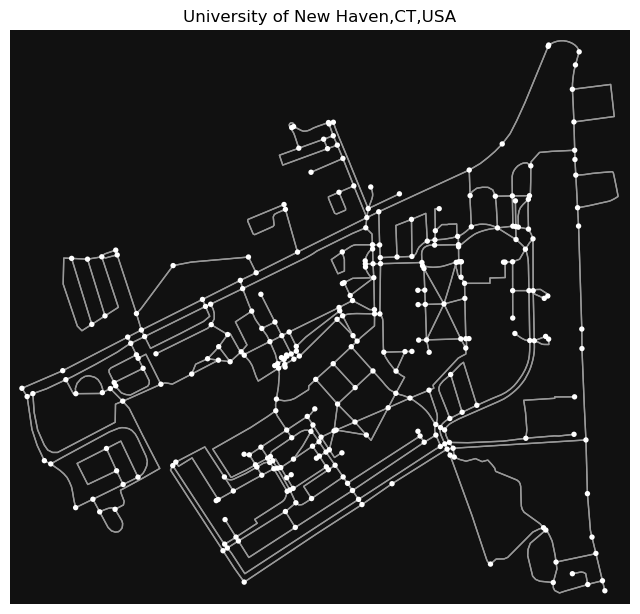

In [3]:
# Set Location
place_name = "University of New Haven,CT,USA"

# Fetch the street network for the set location
G = ox.graph_from_place(place_name, network_type='walk')

# Plot the graph along with place name and geodata
fig, ax = ox.plot_graph(G, show=False, close=False)
ax.set_title(place_name, fontsize=12)  # Set the place name as the title

# Visualise
plt.show()

In [ ]:
# Initialize a geolocator for reverse geocoding
Do not execute
geolocator = GoogleV3(api_key=google_maps_api_key)

# Calculate geographical distances between nodes and set them as edge weights
for u, v, data in G.edges(data=True):
    # Get the latitude and longitude of the nodes
    coords_u = (G.nodes[u]['y'], G.nodes[u]['x'])
    coords_v = (G.nodes[v]['y'], G.nodes[v]['x'])
    
    # Compute the geographical distance between nodes using geodesic
    distance = geodesic(coords_u, coords_v).meters  # Distance in meters
    
    # Set the edge attribute 'weight' with the computed distance
    G[u][v][0]['weight'] = distance  # Setting for the first (0th) edge attribute

# Reverse geocode node names to addresses and update node names accordingly
for node in G.nodes():
    # Get the latitude and longitude of the node
    lat = G.nodes[node]['y']
    lon = G.nodes[node]['x']
    # Reverse geocode to get the address
    location = geolocator.reverse((lat, lon), exactly_one=True)
    if location:
        name = location.address.split(',')[0]
        address=location.address
    
    # Update the node attribute 'address' with the reverse geocoded address
    G.nodes[node]['address'] = address

    # Update the node attribute 'name' with only the node name
    G.nodes[node]['name'] = name
    print("H",G.nodes[node])

In [9]:
# Load the graph from the file
with open('graph.pkl', 'rb') as f:
    loaded_graph = pickle.load(f)

In [18]:
print("Number of Nodes",loaded_graph.number_of_nodes())
print("Number of Edges",loaded_graph.number_of_edges())

Number of Nodes 315
Number of Edges 918


In [13]:
edge_pd=[]
for start,end ,data in G.edges(data=True):
    data['start']=start
    data['end']=end
    edge_pd.append(data)

In [20]:
#saving edge dataframe 
#pd.DataFrame(edge_pd).to_csv('Ai_project_edge_data.csv')
edge_pd=pd.read_csv('Ai_project_edge_data.csv')

In [21]:
edge_pd.head(5)

,Unnamed: 0,osmid,ref,name,highway,oneway,reversed,length,weight,start,end,geometry,service,lanes,maxspeed
0,0,974898386,CT 122,Campbell Avenue,secondary,False,False,18.597,18.574620,178537304,8488049356,NaN,NaN,NaN,NaN
1,1,974898386,CT 122,Campbell Avenue,secondary,False,True,10.990,10.976602,178537304,3437141089,NaN,NaN,NaN,NaN
2,2,168521463,NaN,NaN,service,False,False,22.803,22.845160,178548921,10847123841,NaN,NaN,NaN,NaN
3,3,17229394,NaN,Rockview Street,residential,False,True,62.873,59.776448,178548921,6820965786,"LINESTRING (-72.9662239 41.2891258, -72.966248...",NaN,NaN,NaN
4,4,932573702,NaN,NaN,service,False,False,6.058,6.067299,178552492,6828650373,NaN,parking_aisle,NaN,NaN


In [15]:
node_pd=[]
for x,data in G.nodes(data=True):
    data['id']=x
    node_pd.append(data)

In [24]:
#saving node dataframe 
#pd.DataFrame(node_pd).to_csv('Ai_project_node_data.csv')
node_pd=pd.read_csv('Ai_project_node_data.csv')

In [25]:
node_pd

,Unnamed: 0,y,x,street_count,address,name,id,highway
0,0,41.292846,-72.959123,3,"1201 Campbell Ave, West Haven, CT 06516, USA",1201 Campbell Ave,178537304,NaN
1,1,41.289126,-72.966224,4,"46 Rockview St, West Haven, CT 06516, USA",46 Rockview St,178548921,NaN
2,2,41.288666,-72.964128,4,"137 Ruden St, West Haven, CT 06516, USA",137 Ruden St,178552492,NaN
3,3,41.291804,-72.963766,3,"459 Boston Post Rd, West Haven, CT 06516, USA",459 Boston Post Rd,178568269,NaN
4,4,41.289275,-72.958945,3,"Campbell Ave @ Opp First Ave, West Haven, CT 0...",Campbell Ave @ Opp First Ave,178576160,traffic_signals
...,...,...,...,...,...,...,...,...
310,310,41.290398,-72.965731,3,"422 Boston Post Rd, West Haven, CT 06516, USA",422 Boston Post Rd,11254372334,NaN
311,311,41.290264,-72.965554,4,"9 Daytona St, West Haven, CT 06516, USA",9 Daytona St,11254372335,NaN
312,312,41.289108,-72.965663,3,"24 Rockview St, West Haven, CT 06516, USA",24 Rockview St,11254375544,NaN
313,313,41.290355,-72.965844,3,"488 Boston Post Rd, West Haven, CT 06516, USA",488 Boston Post Rd,11254375545,NaN


In [26]:
# Create a folium map centered at the first node
mymap = folium.Map(location=list((loaded_graph.nodes[178537304]['y'],loaded_graph.nodes[178537304]['x'])), zoom_start=50)

# Plot each node on the map with its name
for node, coordinates in loaded_graph.nodes(data=True):
#     print(node,(loaded_graph.nodes[node]['y'],loaded_graph.nodes[node]['x']),coordinates['name'],coordinates)
#     folium.Marker(location=(loaded_graph.nodes[node]['y'],loaded_graph.nodes[node]['x']), popup=node).add_to(mymap)
    folium.Marker(location=(loaded_graph.nodes[node]['y'],loaded_graph.nodes[node]['x']),popup=node).add_to(mymap)

# Plot edges on the map
for start,end,edge in loaded_graph.edges(data=True):
#     print(start,end,edge)
    start_node=start
    end_node=end
    if start_node==end_node or 'weight' not in edge:
        weight=0
    else:weight = edge['weight']
    folium.PolyLine([(loaded_graph.nodes[start_node]['y'],loaded_graph.nodes[start_node]['x']), (loaded_graph.nodes[end_node]['y'],loaded_graph.nodes[end_node]['x'])], color="black", weight=2.5, opacity=1, popup=f"{weight:.2f} meters").add_to(mymap)

# Save the map to an HTML file
mymap.save("map_with_nodes.html")

In [168]:
start_test=2096427235
end_test=3437140637


In [219]:
def aStarSearch(graph,start,end,heuristic):
    print("start",start)
    print("end",end)
    open_list = [(0, start)]
    heapq.heapify(open_list)
    
    parents = {}
    g_values = {node: float('inf') for node in graph.nodes()}
    g_values[start] = 0
    nodes_expanded=[start]
    count=0
    while open_list:
        
        
        _, current_node = heapq.heappop(open_list)
        count+=1
        nodes_expanded.append(current_node)
        if current_node == end:
            path = [end]
            while end != start:
                path.append(parents[end])
                end = parents[end]
            print("Node Visited",count)
            return (path[::-1],nodes_expanded)
        
        for neighbor in graph.neighbors(current_node):            
            tentative_g_value = g_values[current_node] + graph[current_node][neighbor][0]['weight']
            
            if tentative_g_value < g_values[neighbor]:
                parents[neighbor] = current_node
                g_values[neighbor] = tentative_g_value
                
                f_value = tentative_g_value + heuristic(graph.nodes[neighbor], graph.nodes[end])
                heapq.heappush(open_list, (f_value, neighbor))
                
    
    return None

In [220]:
def haversine(neighbor,end):
#     print("neighbor",neighbor)
#     print("end",end)
    distance_meters = calculate_distance(neighbor['x'],neighbor['y'], end['x'], end['y'])
    return distance_meters

def calculate_distance(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)
    
    # Haversine formula to calculate distance between two points on Earth
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = 6371 * c * 1000  # Radius of Earth in kilometers * distance (in meters)
    
    return distance

In [221]:
def euclidean_distance(node1, node2):
    x1, y1 = node1['x'], node1['y']
    x2, y2 = node2['x'], node2['y']
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

In [222]:
def octile_distance(node1, node2):
    dx = abs(node2['x'] - node1['x'])
    dy = abs(node2['y'] - node1['y'])
    return max(dx, dy) + (math.sqrt(2) - 1) * min(dx, dy)

In [223]:
def chebyshev_distance(node1, node2):
    dx = abs(node2['x'] - node1['x'])
    dy = abs(node2['y'] - node1['y'])
    return max(dx, dy)

In [224]:
def null_heuristic(neighbor,end):
    return 0

In [202]:
#A* Search null
shortest_path,nodes_expanded=aStarSearch(loaded_graph,start_test,end_test,null_heuristic)

start 2096427235
end 3437140637
Node Visited 277


In [203]:
#Plot A* Map
# Create a folium map centered at the first node
mymap = folium.Map(location=list((loaded_graph.nodes[178537304]['y'],loaded_graph.nodes[178537304]['x'])), zoom_start=50)

# Plot each node on the map with its name
for node, coordinates in loaded_graph.nodes(data=True):
#     print(node,(loaded_graph.nodes[node]['y'],loaded_graph.nodes[node]['x']),coordinates['name'],coordinates)
#     folium.Marker(location=(loaded_graph.nodes[node]['y'],loaded_graph.nodes[node]['x']), popup=node).add_to(mymap)
    folium.Marker(location=(loaded_graph.nodes[node]['y'],loaded_graph.nodes[node]['x']),popup=node).add_to(mymap)

# Plot edges on the map
for start,end,edge in loaded_graph.edges(data=True):
#     print(start,end,edge)
    start_node=start
    end_node=end
    if start_node==end_node or 'weight' not in edge:
        weight=0
    else:weight = edge['weight']
    folium.PolyLine([(loaded_graph.nodes[start_node]['y'],loaded_graph.nodes[start_node]['x']), (loaded_graph.nodes[end_node]['y'],loaded_graph.nodes[end_node]['x'])], color="black", weight=2.5, opacity=1, popup=f"{weight:.2f} meters").add_to(mymap)
# Plot the expanded nodes

for node in nodes_expanded:
    path_coordinates = [(loaded_graph.nodes[neighbour]['y'],loaded_graph.nodes[neighbour]['x'])for neighbour in loaded_graph.neighbors(node)]
    folium.PolyLine(path_coordinates, color="Yellow", weight=5, opacity=1).add_to(mymap)

# Plot the shortest path in red
distance=0
for i  in range(len(shortest_path)-1):
#     print(loaded_graph.get_edge_data(shortest_path[i],shortest_path[i+1])[0])
    distance+=loaded_graph.get_edge_data(shortest_path[i],shortest_path[i+1])[0]['weight']
path_coordinates = [(loaded_graph.nodes[node]['y'],loaded_graph.nodes[node]['x'])for node in shortest_path]
folium.PolyLine(path_coordinates, color="red", weight=5, opacity=1, popup=f"Shortest Path: {distance:.2f} meters").add_to(mymap)

# Save the map to an HTML file
mymap.save("map_with_nodes_Astar_null.html")

In [225]:
#A* Search haversine
shortest_path,nodes_expanded=aStarSearch(loaded_graph,start_test,end_test,haversine)

start 2096427235
end 3437140637
Node Visited 149


In [205]:
#Plot A* Map
# Create a folium map centered at the first node
mymap = folium.Map(location=list((loaded_graph.nodes[178537304]['y'],loaded_graph.nodes[178537304]['x'])), zoom_start=50)

# Plot each node on the map with its name
for node, coordinates in loaded_graph.nodes(data=True):
#     print(node,(loaded_graph.nodes[node]['y'],loaded_graph.nodes[node]['x']),coordinates['name'],coordinates)
#     folium.Marker(location=(loaded_graph.nodes[node]['y'],loaded_graph.nodes[node]['x']), popup=node).add_to(mymap)
    folium.Marker(location=(loaded_graph.nodes[node]['y'],loaded_graph.nodes[node]['x']),popup=node).add_to(mymap)

# Plot edges on the map
for start,end,edge in loaded_graph.edges(data=True):
#     print(start,end,edge)
    start_node=start
    end_node=end
    if start_node==end_node or 'weight' not in edge:
        weight=0
    else:weight = edge['weight']
    folium.PolyLine([(loaded_graph.nodes[start_node]['y'],loaded_graph.nodes[start_node]['x']), (loaded_graph.nodes[end_node]['y'],loaded_graph.nodes[end_node]['x'])], color="black", weight=2.5, opacity=1, popup=f"{weight:.2f} meters").add_to(mymap)
# Plot the expanded nodes

for node in nodes_expanded:
    path_coordinates = [(loaded_graph.nodes[neighbour]['y'],loaded_graph.nodes[neighbour]['x'])for neighbour in loaded_graph.neighbors(node)]
    folium.PolyLine(path_coordinates, color="Yellow", weight=5, opacity=1).add_to(mymap)

# Plot the shortest path in red
distance=0
for i  in range(len(shortest_path)-1):
#     print(loaded_graph.get_edge_data(shortest_path[i],shortest_path[i+1])[0])
    distance+=loaded_graph.get_edge_data(shortest_path[i],shortest_path[i+1])[0]['weight']
path_coordinates = [(loaded_graph.nodes[node]['y'],loaded_graph.nodes[node]['x'])for node in shortest_path]
folium.PolyLine(path_coordinates, color="red", weight=5, opacity=1, popup=f"Shortest Path: {distance:.2f} meters").add_to(mymap)

# Save the map to an HTML file
mymap.save("map_with_nodes_Astar_haversine.html")

In [226]:
#A* Search eculidean
shortest_path,nodes_expanded=aStarSearch(loaded_graph,start_test,end_test,euclidean_distance)

start 2096427235
end 3437140637
Node Visited 277


In [207]:
#Plot A* Map
# Create a folium map centered at the first node
mymap = folium.Map(location=list((loaded_graph.nodes[178537304]['y'],loaded_graph.nodes[178537304]['x'])), zoom_start=50)

# Plot each node on the map with its name
for node, coordinates in loaded_graph.nodes(data=True):
#     print(node,(loaded_graph.nodes[node]['y'],loaded_graph.nodes[node]['x']),coordinates['name'],coordinates)
#     folium.Marker(location=(loaded_graph.nodes[node]['y'],loaded_graph.nodes[node]['x']), popup=node).add_to(mymap)
    folium.Marker(location=(loaded_graph.nodes[node]['y'],loaded_graph.nodes[node]['x']),popup=node).add_to(mymap)

# Plot edges on the map
for start,end,edge in loaded_graph.edges(data=True):
#     print(start,end,edge)
    start_node=start
    end_node=end
    if start_node==end_node or 'weight' not in edge:
        weight=0
    else:weight = edge['weight']
    folium.PolyLine([(loaded_graph.nodes[start_node]['y'],loaded_graph.nodes[start_node]['x']), (loaded_graph.nodes[end_node]['y'],loaded_graph.nodes[end_node]['x'])], color="black", weight=2.5, opacity=1, popup=f"{weight:.2f} meters").add_to(mymap)
# Plot the expanded nodes

for node in nodes_expanded:
    path_coordinates = [(loaded_graph.nodes[neighbour]['y'],loaded_graph.nodes[neighbour]['x'])for neighbour in loaded_graph.neighbors(node)]
    folium.PolyLine(path_coordinates, color="Yellow", weight=5, opacity=1).add_to(mymap)

# Plot the shortest path in red
distance=0
for i  in range(len(shortest_path)-1):
#     print(loaded_graph.get_edge_data(shortest_path[i],shortest_path[i+1])[0])
    distance+=loaded_graph.get_edge_data(shortest_path[i],shortest_path[i+1])[0]['weight']
path_coordinates = [(loaded_graph.nodes[node]['y'],loaded_graph.nodes[node]['x'])for node in shortest_path]
folium.PolyLine(path_coordinates, color="red", weight=5, opacity=1, popup=f"Shortest Path: {distance:.2f} meters").add_to(mymap)

# Save the map to an HTML file
mymap.save("map_with_nodes_Astar_eculidean.html")

In [227]:
#A* Search octile
shortest_path,nodes_expanded=aStarSearch(loaded_graph,start_test,end_test,octile_distance)

start 2096427235
end 3437140637
Node Visited 277


In [209]:
#Plot A* Map
# Create a folium map centered at the first node
mymap = folium.Map(location=list((loaded_graph.nodes[178537304]['y'],loaded_graph.nodes[178537304]['x'])), zoom_start=50)

# Plot each node on the map with its name
for node, coordinates in loaded_graph.nodes(data=True):
#     print(node,(loaded_graph.nodes[node]['y'],loaded_graph.nodes[node]['x']),coordinates['name'],coordinates)
#     folium.Marker(location=(loaded_graph.nodes[node]['y'],loaded_graph.nodes[node]['x']), popup=node).add_to(mymap)
    folium.Marker(location=(loaded_graph.nodes[node]['y'],loaded_graph.nodes[node]['x']),popup=node).add_to(mymap)

# Plot edges on the map
for start,end,edge in loaded_graph.edges(data=True):
#     print(start,end,edge)
    start_node=start
    end_node=end
    if start_node==end_node or 'weight' not in edge:
        weight=0
    else:weight = edge['weight']
    folium.PolyLine([(loaded_graph.nodes[start_node]['y'],loaded_graph.nodes[start_node]['x']), (loaded_graph.nodes[end_node]['y'],loaded_graph.nodes[end_node]['x'])], color="black", weight=2.5, opacity=1, popup=f"{weight:.2f} meters").add_to(mymap)
# Plot the expanded nodes

for node in nodes_expanded:
    path_coordinates = [(loaded_graph.nodes[neighbour]['y'],loaded_graph.nodes[neighbour]['x'])for neighbour in loaded_graph.neighbors(node)]
    folium.PolyLine(path_coordinates, color="Yellow", weight=5, opacity=1).add_to(mymap)

# Plot the shortest path in red
distance=0
for i  in range(len(shortest_path)-1):
#     print(loaded_graph.get_edge_data(shortest_path[i],shortest_path[i+1])[0])
    distance+=loaded_graph.get_edge_data(shortest_path[i],shortest_path[i+1])[0]['weight']
path_coordinates = [(loaded_graph.nodes[node]['y'],loaded_graph.nodes[node]['x'])for node in shortest_path]
folium.PolyLine(path_coordinates, color="red", weight=5, opacity=1, popup=f"Shortest Path: {distance:.2f} meters").add_to(mymap)

# Save the map to an HTML file
mymap.save("map_with_nodes_Astar_octile.html")

In [228]:
#A* Search chebyshev
shortest_path,nodes_expanded=aStarSearch(loaded_graph,start_test,end_test,chebyshev_distance)

start 2096427235
end 3437140637
Node Visited 277


In [229]:
#Plot A* Map
# Create a folium map centered at the first node
mymap = folium.Map(location=list((loaded_graph.nodes[178537304]['y'],loaded_graph.nodes[178537304]['x'])), zoom_start=50)

# Plot each node on the map with its name
for node, coordinates in loaded_graph.nodes(data=True):
#     print(node,(loaded_graph.nodes[node]['y'],loaded_graph.nodes[node]['x']),coordinates['name'],coordinates)
#     folium.Marker(location=(loaded_graph.nodes[node]['y'],loaded_graph.nodes[node]['x']), popup=node).add_to(mymap)
    folium.Marker(location=(loaded_graph.nodes[node]['y'],loaded_graph.nodes[node]['x']),popup=node).add_to(mymap)

# Plot edges on the map
for start,end,edge in loaded_graph.edges(data=True):
#     print(start,end,edge)
    start_node=start
    end_node=end
    if start_node==end_node or 'weight' not in edge:
        weight=0
    else:weight = edge['weight']
    folium.PolyLine([(loaded_graph.nodes[start_node]['y'],loaded_graph.nodes[start_node]['x']), (loaded_graph.nodes[end_node]['y'],loaded_graph.nodes[end_node]['x'])], color="black", weight=2.5, opacity=1, popup=f"{weight:.2f} meters").add_to(mymap)
# Plot the expanded nodes

for node in nodes_expanded:
    path_coordinates = [(loaded_graph.nodes[neighbour]['y'],loaded_graph.nodes[neighbour]['x'])for neighbour in loaded_graph.neighbors(node)]
    folium.PolyLine(path_coordinates, color="Yellow", weight=5, opacity=1).add_to(mymap)

# Plot the shortest path in red
distance=0
for i  in range(len(shortest_path)-1):
#     print(loaded_graph.get_edge_data(shortest_path[i],shortest_path[i+1])[0])
    distance+=loaded_graph.get_edge_data(shortest_path[i],shortest_path[i+1])[0]['weight']
path_coordinates = [(loaded_graph.nodes[node]['y'],loaded_graph.nodes[node]['x'])for node in shortest_path]
folium.PolyLine(path_coordinates, color="red", weight=5, opacity=1, popup=f"Shortest Path: {distance:.2f} meters").add_to(mymap)

# Save the map to an HTML file
mymap.save("map_with_nodes_Astar_chebyshev.html")

In [230]:
#DFS
def depth_first_search_path(graph, start, end):
    stack = [(start, [start])]
    visited = set()

    while stack:
        (current, path) = stack.pop()
        visited.add(current)

        if current == end:
            return path, visited

        for neighbor in graph.neighbors(current):
            if neighbor not in visited:
                stack.append((neighbor, path + [neighbor]))
                visited.add(neighbor)

    return None, visited



In [231]:
path, visited_nodes = depth_first_search_path(loaded_graph, start_test, end_test)

In [232]:
print("No of Nodes Visited",len(visited_nodes))

No of Nodes Visited 203


In [233]:
import folium

# Create a folium map centered at the first node
mymap = folium.Map(location=list((loaded_graph.nodes[178537304]['y'],loaded_graph.nodes[178537304]['x'])), zoom_start=50)

# Plot each node on the map with its name
for node, coordinates in loaded_graph.nodes(data=True):
#     print(node,(loaded_graph.nodes[node]['y'],loaded_graph.nodes[node]['x']),coordinates['name'],coordinates)
#     folium.Marker(location=(loaded_graph.nodes[node]['y'],loaded_graph.nodes[node]['x']), popup=node).add_to(mymap)
    folium.Marker(location=(loaded_graph.nodes[node]['y'],loaded_graph.nodes[node]['x']),popup=node).add_to(mymap)

# Plot edges on the map
for start,end,edge in loaded_graph.edges(data=True):
#     print(start,end,edge)
    start_node=start
    end_node=end
    if start_node==end_node or 'weight' not in edge:
        weight=0
    else:weight = edge['weight']
    folium.PolyLine([(loaded_graph.nodes[start_node]['y'],loaded_graph.nodes[start_node]['x']), (loaded_graph.nodes[end_node]['y'],loaded_graph.nodes[end_node]['x'])], color="black", weight=2.5, opacity=1, popup=f"{weight:.2f} meters").add_to(mymap)

# Plot the expanded nodes
path_coordinates=[]
for node in visited_nodes:
    path_coordinates.append((loaded_graph.nodes[node]['y'],loaded_graph.nodes[node]['x']))
    folium.PolyLine(path_coordinates, color="Yellow", weight=5, opacity=1).add_to(mymap)

# Plot the shortest path in red
distance=0
for i  in range(len(path)-1):
#     print(loaded_graph.get_edge_data(shortest_path[i],shortest_path[i+1])[0])
    distance+=loaded_graph.get_edge_data(path[i],path[i+1])[0]['weight']
path_coordinates = [(loaded_graph.nodes[node]['y'],loaded_graph.nodes[node]['x'])for node in path]
folium.PolyLine(path_coordinates, color="red", weight=5, opacity=1, popup=f"Shortest Path: {distance:.2f} meters").add_to(mymap)

# Save the map to an HTML file
mymap.save("map_with_nodes_dfs.html")

In [234]:
def bfs(graph, start, end):
    visited = set()
    queue = deque([(start, [start])])
    visited_nodes = []  # To store visited nodes

    while queue:
        current_node, path = queue.popleft()
        visited.add(current_node)
        visited_nodes.append(current_node)

        if current_node == end:
            return path, visited_nodes

        for neighbor in graph.neighbors(current_node):
            if neighbor not in visited:
                queue.append((neighbor, path + [neighbor]))

    return None, visited_nodes

In [235]:
path, visited_nodes = bfs(loaded_graph, start_test,end_test)

In [236]:
print("No of Nodes Visited",len(visited_nodes))

No of Nodes Visited 1515


In [218]:
import folium

# Create a folium map centered at the first node
mymap = folium.Map(location=list((loaded_graph.nodes[178537304]['y'],loaded_graph.nodes[178537304]['x'])), zoom_start=30)

# Plot each node on the map with its name
for node, coordinates in loaded_graph.nodes(data=True):
#     print(node,(loaded_graph.nodes[node]['y'],loaded_graph.nodes[node]['x']),coordinates['name'],coordinates)
#     folium.Marker(location=(loaded_graph.nodes[node]['y'],loaded_graph.nodes[node]['x']), popup=node).add_to(mymap)
    folium.Marker(location=(loaded_graph.nodes[node]['y'],loaded_graph.nodes[node]['x']),popup=node).add_to(mymap)

# Plot edges on the map
for start,end,edge in loaded_graph.edges(data=True):
#     print(start,end,edge)
    start_node=start
    end_node=end
    if start_node==end_node or 'weight' not in edge:
        weight=0
    else:weight = edge['weight']
    folium.PolyLine([(loaded_graph.nodes[start_node]['y'],loaded_graph.nodes[start_node]['x']), (loaded_graph.nodes[end_node]['y'],loaded_graph.nodes[end_node]['x'])], color="black", weight=2.5, opacity=1, popup=f"{weight:.2f} meters").add_to(mymap)

# Plot the expanded nodes
path_coordinates=[]
for node in visited_nodes:
    path_coordinates.append((loaded_graph.nodes[node]['y'],loaded_graph.nodes[node]['x']))
    folium.PolyLine(path_coordinates, color="Yellow", weight=5, opacity=1).add_to(mymap)

# Plot the shortest path in red
distance=0
for i  in range(len(path)-1):
#     print(loaded_graph.get_edge_data(shortest_path[i],shortest_path[i+1])[0])
    distance+=loaded_graph.get_edge_data(path[i],path[i+1])[0]['weight']
path_coordinates = [(loaded_graph.nodes[node]['y'],loaded_graph.nodes[node]['x'])for node in path]
folium.PolyLine(path_coordinates, color="red", weight=5, opacity=1, popup=f"Shortest Path: {distance:.2f} meters").add_to(mymap)

# Save the map to an HTML file
mymap.save("map_with_nodes_bfs.html")